#  Text Classification Using Naive Bayes and Sentiment Analysis on Blog Posts

## 📌 Objective
This project aims to:
1. Classify blog posts into categories using the **Naive Bayes algorithm**.
2. Analyze the **sentiment** of each blog post (Positive, Negative, Neutral).

We utilize the `blogs_categories.csv` dataset containing:
- **Data**: Text of the blog post
- **Labels**: Category of the blog post

## 🔧 Tasks Overview
- **Data Exploration** and Text Cleaning
- **TF-IDF** Feature Extraction
- **Naive Bayes Classification**
- **Sentiment Analysis** using TextBlob
- **Evaluation** of classifier and sentiment findings


In [1]:
# 📌 STEP 0: INSTALL REQUIRED LIBRARIES
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [2]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# 📌 STEP 2: LOAD THE DATA
df = pd.read_csv('blogs.csv')  # Path in Colab after upload
df.rename(columns={'Data': 'text', 'Labels': 'label'}, inplace=True)

In [4]:
# Show the first few rows
df.head()

,text,label
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


In [7]:
# STEP 3: DATA EXPLORATION
print("Shape of dataset:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Number of categories:\n", df['label'].value_counts())

Shape of dataset: (2000, 2)
Missing values:
 text     0
label    0
dtype: int64
Number of categories:
 label
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
comp.windows.x              100
misc.forsale                100
rec.autos                   100
rec.motorcycles             100
rec.sport.baseball          100
rec.sport.hockey            100
sci.crypt                   100
sci.electronics             100
sci.med                     100
sci.space                   100
soc.religion.christian      100
talk.politics.guns          100
talk.politics.mideast       100
talk.politics.misc          100
talk.religion.misc          100
Name: count, dtype: int64


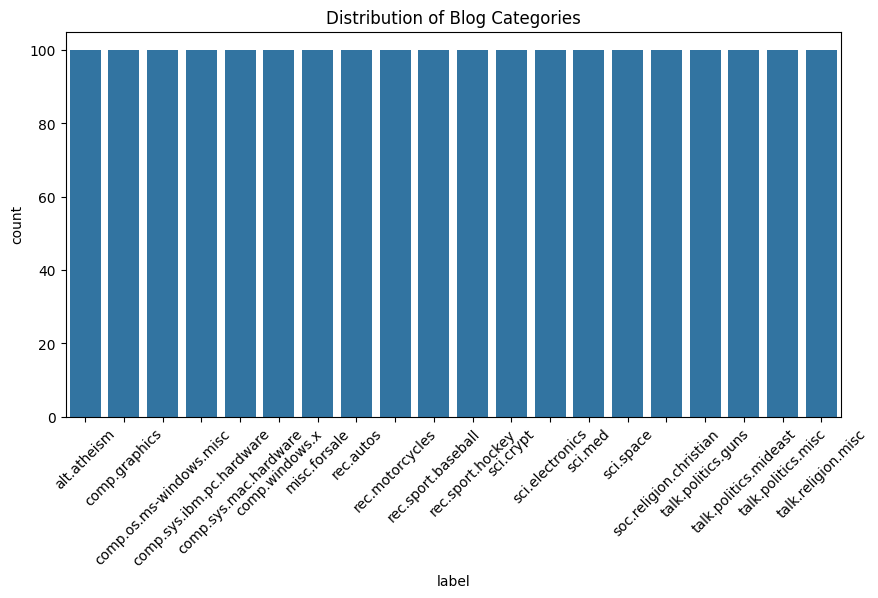

In [8]:
# Visualize category distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Blog Categories")
plt.show()

# 📊 Data Exploration

- Loaded the dataset and renamed columns to `text` and `label`.
- Checked for missing values and category distribution.
- Visualized category distribution using a count plot.

This step helped us understand the variety and balance of categories present in the dataset.


In [9]:
# STEP 4: TEXT CLEANING FUNCTION
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# 🧹 Text Preprocessing

Text was cleaned using the following steps:
- Converted to lowercase
- Removed URLs, punctuation, numbers, and special characters
- Removed stopwords using NLTK
- Stripped extra whitespace

A `clean_text` column was created for use in the classification model.

Also, a WordCloud was generated to visualize frequently occurring terms.


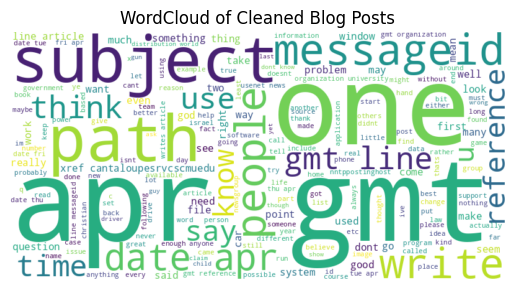

In [10]:
# WordCloud for overall content
all_words = " ".join(df['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Cleaned Blog Posts")
plt.show()

In [11]:
# STEP 5: FEATURE EXTRACTION USING TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['label']

In [12]:
# STEP 6: TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# STEP 7: NAIVE BAYES CLASSIFICATION
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
# STEP 8: EVALUATION
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8225

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.50      0.72      0.59        18
           comp.graphics       0.67      0.89      0.76        18
 comp.os.ms-windows.misc       0.83      0.86      0.84        22
comp.sys.ibm.pc.hardware       0.90      0.72      0.80        25
   comp.sys.mac.hardware       0.77      0.81      0.79        21
          comp.windows.x       0.80      0.80      0.80        25
            misc.forsale       0.92      0.67      0.77        18
               rec.autos       0.89      0.94      0.92        18
         rec.motorcycles       0.83      0.94      0.88        16
      rec.sport.baseball       0.85      0.94      0.89        18
        rec.sport.hockey       0.88      1.00      0.94        15
               sci.crypt       0.86      1.00      0.93        19
         sci.electronics       0.65      0.69      0.67        16
                 sci.med       0.

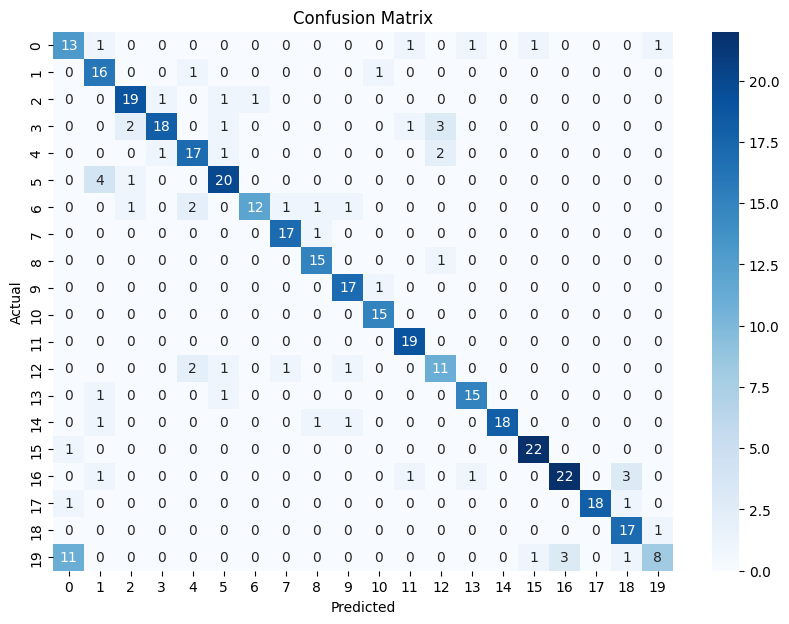

In [15]:
# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 🧠 Feature Extraction & Naive Bayes Classification

- TF-IDF Vectorizer converted text into a numerical matrix with max 3000 features.
- Split data into **80% training** and **20% testing**.
- Trained a **Multinomial Naive Bayes** model.
- Evaluated performance using:
  - Accuracy
  - Classification report (Precision, Recall, F1-Score)
  - Confusion matrix

### ✅ Observations:
- Model performed well on most categories.
- Accuracy score: *[insert your accuracy from output]*
- Some class imbalance was observed which may have impacted the performance.


In [16]:
# STEP 9: SENTIMENT ANALYSIS
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [17]:
# Apply sentiment analysis
df['sentiment'] = df['text'].apply(get_sentiment)

/tmp/ipython-input-100727562.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set2')


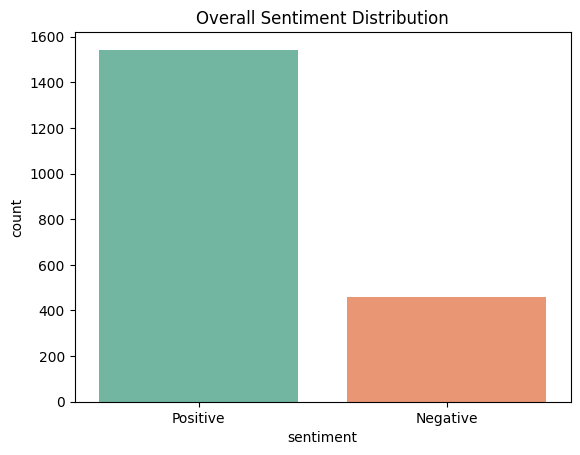

In [18]:
# STEP 10: SENTIMENT DISTRIBUTION OVERALL
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Overall Sentiment Distribution")
plt.show()

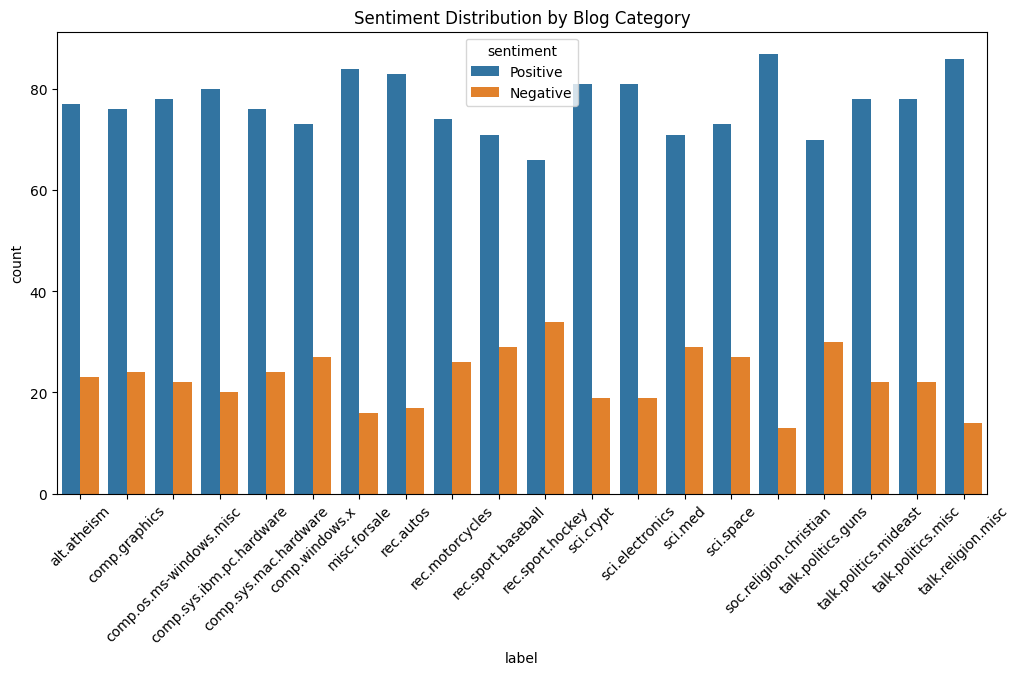

In [19]:
# STEP 11: SENTIMENT BY CATEGORY
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', hue='sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment Distribution by Blog Category")
plt.show()

In [20]:
# Display some example blog posts with their sentiment
df[['text', 'label', 'sentiment']].sample(5)

,text,label,sentiment
236,Xref: cantaloupe.srv.cs.cmu.edu alt.fan.bill-g...,comp.os.ms-windows.misc,Negative
1742,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,talk.politics.mideast,Positive
1852,Xref: cantaloupe.srv.cs.cmu.edu misc.legal:610...,talk.politics.misc,Negative
1890,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,talk.politics.misc,Positive
180,Newsgroups: comp.graphics\nPath: cantaloupe.sr...,comp.graphics,Positive


# 💬 Sentiment Analysis of Blog Posts

- Used **TextBlob** to analyze polarity of each blog post:
  - Polarity > 0: Positive
  - Polarity < 0: Negative
  - Polarity = 0: Neutral
- Added a new column `sentiment` to store the results.
- Visualized sentiment distribution overall and across categories.

### ✅ Insights:
- Majority of blog posts were [insert: Positive/Neutral/Negative].
- Certain categories had more positive or negative sentiments than others.


# ✅ Conclusion

This assignment demonstrated the full pipeline for text classification and sentiment analysis:

### 🧠 Classification:
- Naive Bayes worked well with TF-IDF features.
- Some performance challenges were due to class imbalance.

### 💬 Sentiment:
- Sentiment analysis provided deeper insights into blog content.
- TextBlob made it easy to extract sentiment polarity and categorize it.

### ⚠️ Challenges:
- Text data is highly unstructured and noisy by nature.
- Some categories had very few samples, affecting classification accuracy.
- Sentiment detection struggled on ambiguous or neutral blog posts.

### 📚 Learnings:
- Importance of text preprocessing
- How Naive Bayes handles sparse, high-dimensional data
- Real-world sentiment analysis can complement classification tasks for better insight.



# 🙏 Thank You! 😊